In [1]:
from deepsudoku import REPO_PATH, DIFFICULTIES
import os
os.chdir(REPO_PATH)

import tensorflow as tf
import numpy as np
from deepsudoku.reinforcement_learning.ppo import *

import gymnasium as gym
from deepsudoku.verify_sudoku import *

2023-08-29 11:22:03.888737: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 11:22:03.922005: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 11:22:03.922978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 11:22:04.709844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


In [2]:
size = 3
sq_size = np.square(size)
sudoku_input_shape = (sq_size, sq_size, sq_size+1)
missing_digits = 5

In [3]:
# Create Discrete models

# Implementation Detail 2: Orthogonal Initialization of hidden weights and constant initialization of biases and output weights
# Biases seem to be 0 by default in Keras
hidden_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=np.sqrt(2))
pol_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=0.01)
val_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=1)

def create_policy_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Conv2D(16, 3, padding="same", data_format="channels_last", activation="relu", kernel_initializer=hidden_ortho_init())(inputs)
    x = tf.keras.layers.Conv2D(16, 3, padding="same", data_format="channels_last", activation="relu", kernel_initializer=hidden_ortho_init())(x)
    x = tf.keras.layers.Conv2D(9, 9, padding="same", data_format="channels_last", activation="linear", kernel_initializer=pol_out_ortho_init())(x)
    outputs = tf.keras.layers.Flatten(data_format="channels_last")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pi")
    return model

def create_value_function_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    pre = tf.keras.layers.Flatten(data_format="channels_last")(inputs)
    x = tf.keras.layers.Dense(128, activation="tanh", kernel_initializer=hidden_ortho_init())(pre)
    x = tf.keras.layers.Dense(256, activation="tanh", kernel_initializer=hidden_ortho_init())(x)
    outputs = tf.keras.layers.Dense(1, activation="linear", kernel_initializer=val_out_ortho_init())(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="V")
    return model

In [4]:
# create sudoku action mask
def action_mask(observation, logits):
    for y, x in np.ndindex(observation.shape):
        if observation[y,x] != 0:
            act_space_ind = y*(sq_size**2)+x*(sq_size)
            #converting from sudoku-board index to action-space index, see env.py
            logits[act_space_ind:act_space_ind+sq_size] = -1e8
    return logits

In [5]:
def preprocessing(observation):
    return tf.one_hot(observation, 10, axis=-1)

In [6]:
envs = PPO_Discrete_Environment_Wrapper('Sudoku-x0', 50, action_mask = action_mask, size=size, missing_digits=missing_digits, preprocessing_function=preprocessing)

In [7]:
pi, V = PPO(envs, create_policy_model(), create_value_function_model(), multi_discrete=False, STEPS_PER_TRAJECTORY=50, TRAIN_EPOCHS = 1000, LEARNING_RATE_START=0.001)

epoch:  0  ; KL:  0  ; LR:  0.001  ; MR:  0
Collection
Tapework
epoch:  1  ; KL:  2.0625715  ; LR:  0.000999  ; MR:  1.0308
Collection
Tapework
epoch:  2  ; KL:  0.2709505  ; LR:  0.000998  ; MR:  0.302
Collection
Tapework
epoch:  3  ; KL:  0.2157212  ; LR:  0.000997  ; MR:  -0.3676
Collection
Tapework
epoch:  4  ; KL:  0.2219712  ; LR:  0.000996  ; MR:  -0.4556
Collection
Tapework
epoch:  5  ; KL:  0.20595229  ; LR:  0.000995  ; MR:  -0.4968
Collection
Tapework
epoch:  6  ; KL:  0.16540332  ; LR:  0.000994  ; MR:  -0.3408
Collection
Tapework
epoch:  7  ; KL:  0.21549281  ; LR:  0.000993  ; MR:  -0.294
Collection
Tapework
epoch:  8  ; KL:  0.20239559  ; LR:  0.000992  ; MR:  0.0524
Collection
Tapework
epoch:  9  ; KL:  0.21836826  ; LR:  0.000991  ; MR:  0.168
Collection
Tapework
epoch:  10  ; KL:  0.2858253  ; LR:  0.00099  ; MR:  0.5548
Collection
Tapework
epoch:  11  ; KL:  0.4795146  ; LR:  0.000989  ; MR:  0.5048
Collection
Tapework
epoch:  12  ; KL:  0.5935794  ; LR:  0.000988  ;

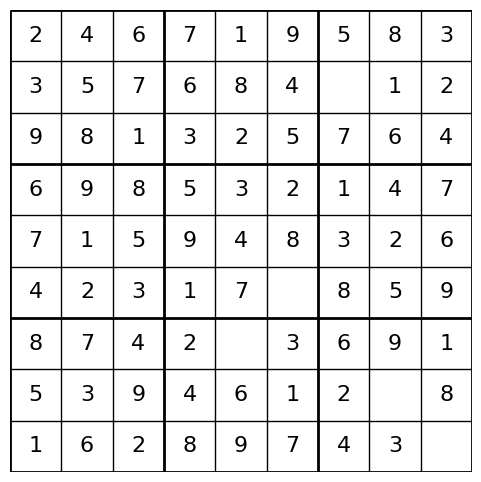

In [8]:

test_env = gym.make('Sudoku-x0', render_mode='human', size=size, missing_digits=missing_digits)
#test_env = gym.make('CartPole-v1', render_mode='human')


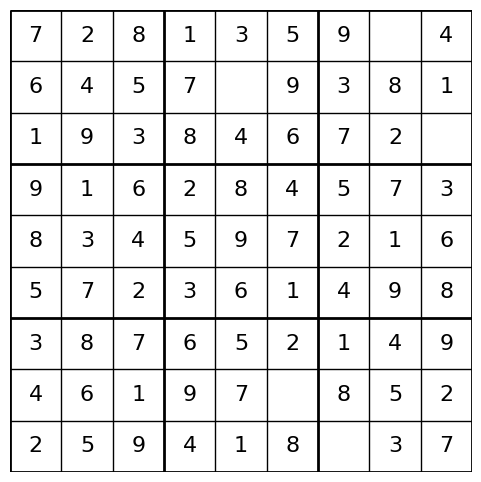

In [28]:
obs, inf = test_env.reset()
test_env.render()

248 False -1


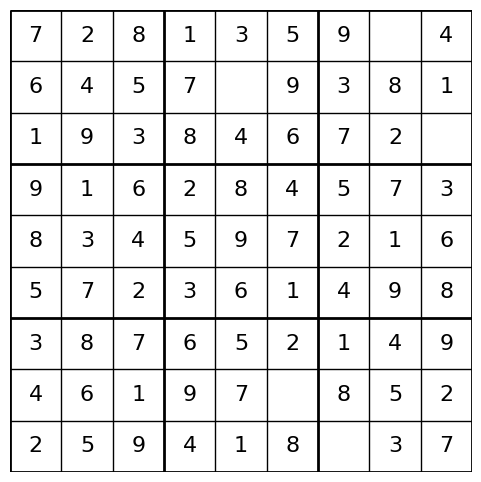

In [29]:
qs = pi(tf.expand_dims(preprocessing(obs), 0))
act = np.argmax(qs)
obs, reward, terminated, _, _ = test_env.step(act)
print(act, terminated, reward)
test_env.render()